In [ ]:
#1. we want output to have no pre-assumption, ie, not confidently wrong guessing
#by setting b2 to 0, W2 to small random values (not to be zero, otherwise it will not learn)
#2. avoiding saturation of neuron, h close to zero, (becasue of Tanh function)
#by normalizing the linear layer (before Tanh layer) to Guassian
#batch normalizaton apply to each batch 

In [472]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [473]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [474]:
len(words)

32033

In [475]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [476]:
#build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size # [0, 0 ,0]
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [479]:
n_embd = 10 # dims of char embedding vectors
n_hidden = 200 #no. of neurons in the hidden layer of MLP
#for manually set the initialization parameters: (not BN)
#for deeper NN, it is difficult to set the initial weigthing of parameters, we need batchNorm
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *  (5/3)/((n_embd * block_size)**0.5) # gain of Tahn / sqrt of (out_fan)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #*  prevent dead neuron, ie, saturated (h == 1, -1)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #scale down the logits --> 0s  --> initial gess close to 
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # we want logits be small initially (prevent confidently wrong)           

#we don't want parameters always be Gussian, only want in the initial state, 
#and let backprop tell us to moving aroung the gussian..., we need following: gain & shift
bngain = torch.ones((1, n_hidden)) #gain==1, no effect on initial stage to the distribution
bnbias = torch.zeros((1, n_hidden)) #shift==0, no effect on initial stage to the distribution

#below mean/std no need for gradient descent learning, it will be update smoothly with torch.no_grac():
bnmean_running = torch.zeros((1, n_hidden)) #for on-the-fly calibration, u=0, std=1, ie. normal dist.
bnstd_running = torch.ones((1, n_hidden))   #for no-the-fly calibration

parameters = [C, W1, W2, b2, bngain, bnbias] #parameters to be learned during backprop
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True
    
#in initialization, we want logits close to 0s, ie., no extreme value, --> confidently wrong initial guess !
#if W2 set to exact 0s, then h will became many 1s and -1s, will make the learning in backprop 
#VERY slow !
#BN causes every single sample linked to other samples in the batch mathematically --> regulatorization effect

12097


In [601]:
max_steps = 200000
batch_size = 32
lossi = []

for i  in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  + b1
    h = torch.tanh(hpreact)
    #we want logits initialized close to zeros  --> initial guess without strong assumption
    logits = h @ W2 + b2 # output layer (32, 27) remember 32 is the batch size (m)
    loss = F.cross_entropy(logits, Yb) #loss function
    
    for p in parameters:
        p.grad = None     # initializing all grad to zero b4 backward
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  
    
   
  

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
#initial guess among 27 chars without any assumption
-torch.tensor(1/27.0).log()

In [480]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #mini batch , randomly select 32 training data with sample replacement
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    #forward pass
    emb = C[Xb] #embed the chars into vectors (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1)   #concatenate the vectors (32, 30)
    #Linear layer     we don't need b1 here...bias is governed by bnbias
    hpreact = embcat @ W1  #+ b1 # hidden layer pre-activation (32, 200), bnbias can replace b1, ie., b1 is redundant
    #BatchNorm layer - control the statistic of the layer efficiently
    #----------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True) #(1, 200) mean of currrent batch (32 samples)
    bnstdi = hpreact.std(0, keepdim=True)   #(1, 200) std of current batch (32 samples)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #batch normalization    
    
    #calibration on the fly besides of training , ie., no grad update and no need post training calabration
    #smooth update by little bit amount by current batch
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #----------------------------------------------------------------------
    #Non-linear layer
    h = torch.tanh(hpreact) #hidden layer (32, 200)
    logits = h @ W2 + b2 # output layer (32, 27) remember 32 is the batch size (m)
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None     # initializing all grad to zero b4 backward
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3239


In [449]:
#calibrate the batch norm at the end of training
#for the purpose for feeding a single sample to give prediction by the normalization of 
#entired training sample set during testing test, (because batchnorm is normalized by the sample batch
#which is NOT suitable for prediction --> normalized by entire training set)
#this calibrate can be skip by the calibration on-the-fly method implemented above
with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
#we can check that bnmean, bnstd roughtly == to bnmean_running, bnstd_running

In [456]:
#evaluate the model performance on train/val dataset
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
        
    emb = C[x] #(N, block_size, n_embd); here N is batch_size
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation (32, 200)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization
    
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running +bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 #(N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
    

train 2.066591739654541
val 2.1050572395324707


In [488]:
h.view(-1).tolist() == 1

False

(array([153., 196., 174., 171., 173., 173., 131., 138., 130., 124., 113.,
        140., 124., 113., 109., 120., 120., 104., 123., 105., 105., 104.,
         94., 117., 111., 111.,  85.,  88.,  72.,  98.,  94., 127., 105.,
         88., 111., 110., 127., 112., 103., 124., 134., 130., 132., 149.,
        151., 179., 158., 192., 196., 159.]),
 array([-9.97799933e-01, -9.57872003e-01, -9.17944074e-01, -8.78016144e-01,
        -8.38088214e-01, -7.98160285e-01, -7.58232355e-01, -7.18304425e-01,
        -6.78376496e-01, -6.38448566e-01, -5.98520637e-01, -5.58592707e-01,
        -5.18664777e-01, -4.78736848e-01, -4.38808918e-01, -3.98880988e-01,
        -3.58953059e-01, -3.19025129e-01, -2.79097199e-01, -2.39169270e-01,
        -1.99241340e-01, -1.59313411e-01, -1.19385481e-01, -7.94575512e-02,
        -3.95296216e-02,  3.98308039e-04,  4.03262377e-02,  8.02541673e-02,
         1.20182097e-01,  1.60110027e-01,  2.00037956e-01,  2.39965886e-01,
         2.79893816e-01,  3.19821745e-01,  3.59749

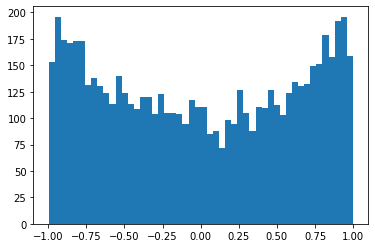

In [481]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   2.,   3.,   4.,  12.,  11.,  22.,  31.,  33.,  52.,
         79.,  97., 113., 148., 160., 232., 224., 254., 293., 335., 339.,
        368., 358., 360., 313., 327., 337., 275., 282., 237., 217., 198.,
        142., 135., 112.,  70.,  66.,  35.,  48.,  27.,  19.,  13.,   4.,
          5.,   3.,   1.,   1.,   0.,   1.]),
 array([-3.40565395, -3.26492825, -3.12420254, -2.98347683, -2.84275112,
        -2.70202541, -2.56129971, -2.420574  , -2.27984829, -2.13912258,
        -1.99839687, -1.85767117, -1.71694546, -1.57621975, -1.43549404,
        -1.29476833, -1.15404263, -1.01331692, -0.87259121, -0.7318655 ,
        -0.59113979, -0.45041409, -0.30968838, -0.16896267, -0.02823696,
         0.11248875,  0.25321445,  0.39394016,  0.53466587,  0.67539158,
         0.81611729,  0.95684299,  1.0975687 ,  1.23829441,  1.37902012,
         1.51974583,  1.66047153,  1.80119724,  1.94192295,  2.08264866,
         2.22337437,  2.36410007,  2.50482578,  2.64555149,  2.7862772 ,
 

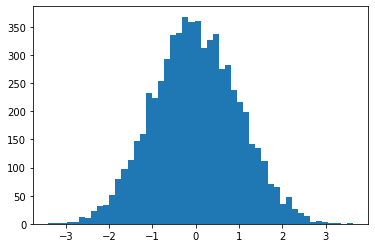

In [482]:
plt.hist(hpreact.view(-1).tolist(), 50)

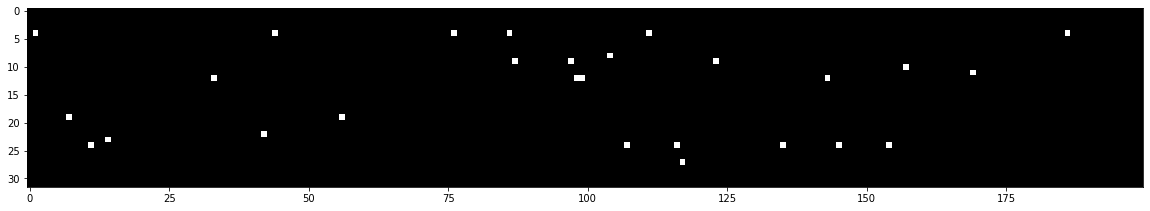

In [483]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
#for any vertical white column, is a dead neuron, ie., no sample can activate that neuron.



In [49]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [490]:
logits[0].sum()

tensor(0.4266, grad_fn=<SumBackward0>)

In [38]:
h.shape

torch.Size([32, 200])

In [607]:
#train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.randn(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.zeros(dim)
        self.beta = torch.zeros(dim)
        #buffers (training with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grid():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmeann
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 #the dim of the character embedding vectors
n_hidden = 100 # the no. of neurons in the hidden layer fo MLP
g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].weight *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()] #double comprehension
print(sum(p.nelement() for p in parameters)) # no. of parameters in total
for p in parameters:
    p.requires_grad = True
        
            

46497


In [608]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # cancatente the vectors
    for layer in layers: #sequential layer adding
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break # aFTER_DEBUG : would tak out obviously to run full optimizatio


      0/ 200000: 3.2047


layer 1 (      Tanh): mean -0.04, std 0.79, saturated: 27.19%
layer 3 (      Tanh): mean -0.00, std 0.76, saturated: 21.09%
layer 5 (      Tanh): mean -0.06, std 0.74, saturated: 18.69%
layer 7 (      Tanh): mean +0.05, std 0.74, saturated: 18.53%
layer 9 (      Tanh): mean -0.02, std 0.74, saturated: 16.53%


Text(0.5, 1.0, 'activation distribution')

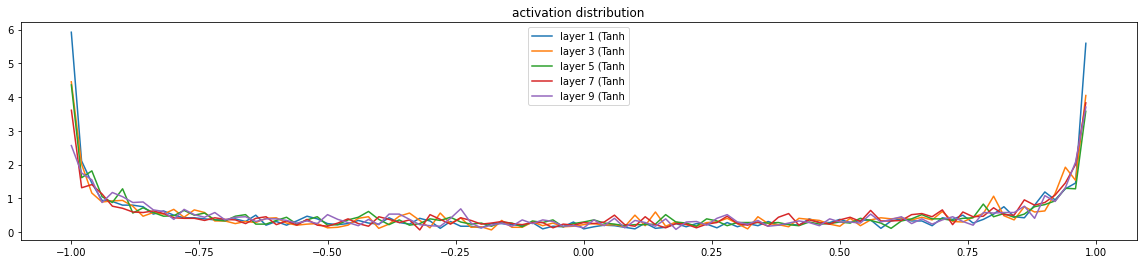

In [609]:
#visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends= []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')



layer 0 (    Linear): mean -0.000000, std 1.273627e-04
layer 2 (    Linear): mean +0.000004, std 1.534877e-04
layer 4 (    Linear): mean +0.000005, std 1.613325e-04
layer 6 (    Linear): mean +0.000007, std 1.677475e-04
layer 8 (    Linear): mean +0.000007, std 1.730815e-04


Text(0.5, 1.0, 'gradient distribution')

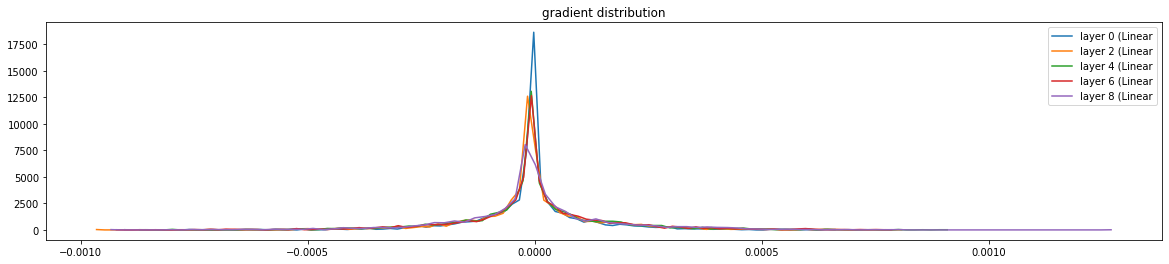

In [610]:
#visualize histograms
plt.figure(figsize=(20, 4)) # width and height 
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000009 | std 7.197317e-04 | grad:data ratio 7.192140e-04
weight  (30, 100) | mean -0.000012 | std 6.807675e-04 | grad:data ratio 2.182910e-03
weight (100, 100) | mean -0.000008 | std 7.059571e-04 | grad:data ratio 4.249688e-03
weight (100, 100) | mean -0.000003 | std 8.284127e-04 | grad:data ratio 4.934432e-03
weight (100, 100) | mean -0.000019 | std 8.660408e-04 | grad:data ratio 5.180232e-03
weight (100, 100) | mean +0.000015 | std 9.259940e-04 | grad:data ratio 5.533481e-03
weight  (100, 27) | mean -0.000000 | std 3.357692e-02 | grad:data ratio 3.221260e+00


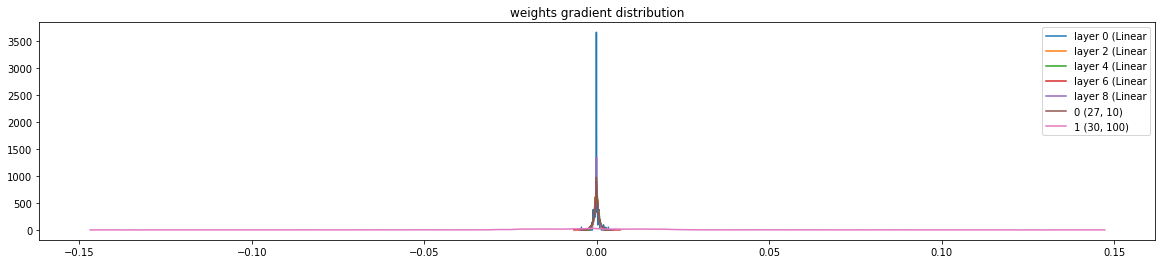

In [611]:
#visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legens = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');